# 

title: Vegetation Data Access

subtitle: Accessing NDVI data on Tribal Subdivisions

description: \|

For the vegetation health coding challenge, you used some sample data
that we packaged up for you. In this lesson, we’’ll go through how we
got that data. Give it a try, and then modify it to answer your own
scientific question!

params:

id: stars

site_name: Gila River Indian Community

data_dir: gila-river

download_key: gila-river-ndvi

project_title: Gila River Vegetation

jupyter:

kernelspec:

    name: learning-portal

    language: python

    display_name: Learning Portal

# STEP 2: AppEEARS API

# STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [4]:
%store -r 

Unable to restore variable 'ndvi_diff', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


You will also need to import any libraries you are using in this
notebook, since they won’t carry over from the previous notebook:

In [5]:
# Import libraries
import os
import pathlib

import hvplot.pandas
import hvplot.xarray

import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import pandas as pd

import earthpy
import earthpy.api.appeears as eaapp

## Exploring the AppEEARS API for NASA Earthdata access

Before you get started with the data download today, you will need a
free [NASA Earthdata account](https://urs.earthdata.nasa.gov/home) if
you don’t have one already!

Over the next four cells, you will download MODIS NDVI data for the
study period. MODIS is a multispectral instrument that measures Red and
NIR data (and so can be used for NDVI). There are two MODIS sensors on
two different platforms: satellites Terra and Aqua.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p><a href="https://modis.gsfc.nasa.gov/">Learn more about MODIS
datasets and the science they support</a></p></div></div>

Since we’re asking for a special download that only covers our study
area, we can’t just find a link to the data - we have to negotiate with
the data server. We’re doing this using the
[APPEEARS](https://appeears.earthdatacloud.nasa.gov/api/) API
(Application Programming Interface). The API makes it possible for you
to request data using code. You can use code from the `earthpy` library
to handle the API request.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Often when we want to do something more complex in coding we find an
example and modify it. This download code is already almost a working
example. Your task will be:</p>
<ol type="1">
<li>Replace the start and end dates in the task parameters. Download
data from July, when greenery is at its peak in the Northern
Hemisphere.</li>
<li>Replace the year range. You should get 3 years before and after the
event so you can see the change!</li>
<li>Replace <code>gdf</code> with the name of <strong>your</strong> site
geodataframe.</li>
<li><strong>Enter your NASA Earthdata username and password when
prompted.</strong> The prompts can be a little hard to see – look at the
top of your screen!</li>
</ol></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What would the product and layer name be if you were trying to
download Landsat Surface Temperature Analysis Ready Data (ARD) instead
of MODIS NDVI?</p></div></div>

> **Important**
>
> It can take some time for Appeears to process your request - anything
> from a few minutes to a few hours depending on how busy they are. You
> can check your progress by:
>
> 1.  Going to the [Appeears
>     webpage](https://appeears.earthdatacloud.nasa.gov/)
> 2.  Clicking the `Explore` tab
> 3.  Logging in with your Earthdata account

In [6]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='elkhorn_fire_ndvi',
    project=project,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="06-01",
    end_date="09-01",
    recurring=True,
    year_range=[2020, 2025],
    polygon=elkhorn_id
)

In [7]:
# Download the prepared download -- this can take some time!
ndvi_downloader.download_files(cache=True)

<generator object Path.rglob at 0x77fb1798e790>

## Putting it together: Working with multi-file raster datasets in Python

Now you need to load all the downloaded files into Python. You may have
noticed that the \`earthpy.appears module gives us all the downloaded
file names…but only some of those are the NDVI files we want while
others are quality files that tell us about the confidence in the
dataset. For now, the files we want all have “NDVI” in the name.

Let’s start by getting all the NDVI file names. You will also need to
extract the date from the filename. Check out [the lesson on getting
information from filenames in the
textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).

> **GOTCHA ALERT!**
>
> `glob` doesn’t necessarily find files in the order you would expect.
> Make sure to **sort** your file names like it says in the textbook.

In [8]:
# Get a sorted list of NDVI tif file paths
ndvi_paths = sorted(list(project.project_dir.rglob('*NDVI*.tif')))

# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([PosixPath('/workspaces/data/gila-rj-veg-data/elkhorn_fire_ndvi/MOD13Q1.061_2020138_to_2025244/MOD13Q1.061__250m_16_days_NDVI_doy2020145000000_aid0001.tif'),
  PosixPath('/workspaces/data/gila-rj-veg-data/elkhorn_fire_ndvi/MOD13Q1.061_2020138_to_2025244/MOD13Q1.061__250m_16_days_NDVI_doy2020161000000_aid0001.tif'),
  PosixPath('/workspaces/data/gila-rj-veg-data/elkhorn_fire_ndvi/MOD13Q1.061_2020138_to_2025244/MOD13Q1.061__250m_16_days_NDVI_doy2020177000000_aid0001.tif')],
 [PosixPath('/workspaces/data/gila-rj-veg-data/elkhorn_fire_ndvi/MOD13Q1.061_2020138_to_2025244/MOD13Q1.061__250m_16_days_NDVI_doy2025209000000_aid0001.tif'),
  PosixPath('/workspaces/data/gila-rj-veg-data/elkhorn_fire_ndvi/MOD13Q1.061_2020138_to_2025244/MOD13Q1.061__250m_16_days_NDVI_doy2025225000000_aid0001.tif'),
  PosixPath('/workspaces/data/gila-rj-veg-data/elkhorn_fire_ndvi/MOD13Q1.061_2020138_to_2025244/MOD13Q1.061__250m_16_days_NDVI_doy2025241000000_aid0001.tif')])

### Repeating tasks in Python

Now you should have a few dozen files! For each file, you need to:

-   Load the file in using the `rioxarray` library
-   Get the date from the file name
-   Add the date as a dimension coordinate
-   Give your data variable a name

You don’t want to write out the code for each file! That’s a recipe for
**copy pasta** and errors. Luckily, Python has tools for doing similar
tasks repeatedly. In this case, you’ll use one called a `for` loop.

There’s some code below that uses a `for` loop in what is called an
**accumulation pattern** to process each file. That means that you will
save the results of your processing to a list each time you process the
files, and then merge all the arrays in the list.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ul>
<li>Look at the file names. How many characters from the end is the
date? <code>doy_start</code> and <code>doy_end</code> are used to
extract the day of the year (doy) from the file name. You will need to
count characters from the end and change the values to get the right
part of the file name. HINT: the index -1 in Python means the last
value, -2 second-to-last, and so on.</li>
<li>Replace any required variable names with your chosen variable
names</li>
</ul></div></div>

In [9]:
doy_start = -25
doy_end = -19 

# Loop through each NDVI image
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy= ndvi_path.name[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, mask_and_scale=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Prepare for concatenation
    ndvi_das.append(da)

### Return Length to list
len(ndvi_das)

42

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Next, stack your arrays by date into a time series:</p>
<ol type="1">
<li>Modify the code to match your prior workflow steps and to use
descriptive variable names</li>
<li>Replace <code>coordinate_name</code> with the actual name of the
coordinate you want to build up.</li>
</ol></div></div>

In [10]:
# Combine NDVI images from all dates
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

/tmp/ipykernel_1530/3809486676.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
/tmp/ipykernel_1530/3809486676.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])


<xarray.Dataset> Size: 1MB
Dimensions:      (date: 42, y: 64, x: 101)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 808B -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 512B 45.62 45.61 45.61 45.61 ... 45.49 45.49 45.48
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 336B 2020-01-14 2020-01-16 ... 2025-01-24
Data variables:
    NDVI         (date, y, x) float32 1MB 0.4451 0.5387 0.5387 ... 0.5484 0.5811

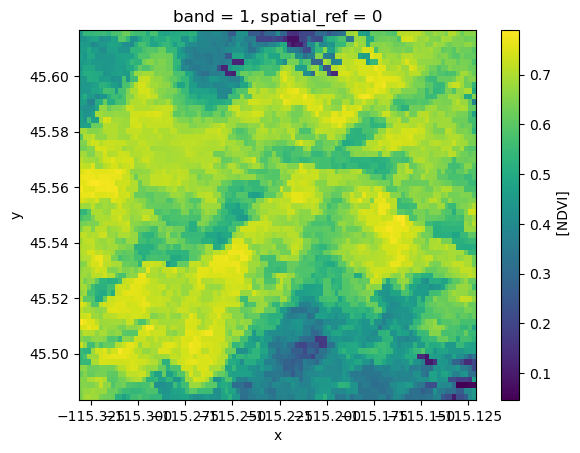

In [11]:
# plot the 1st tif image
rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze().plot()

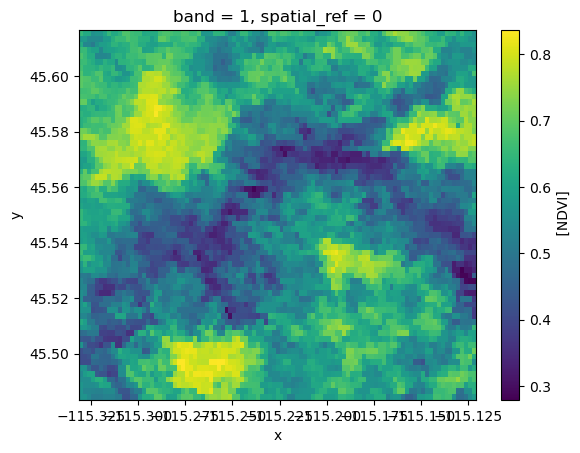

In [12]:
# plot the last tif image
rxr.open_rasterio(ndvi_paths[-1], mask_and_scale=True).squeeze().plot()

In [13]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Elk_Horn_Post_Fire')

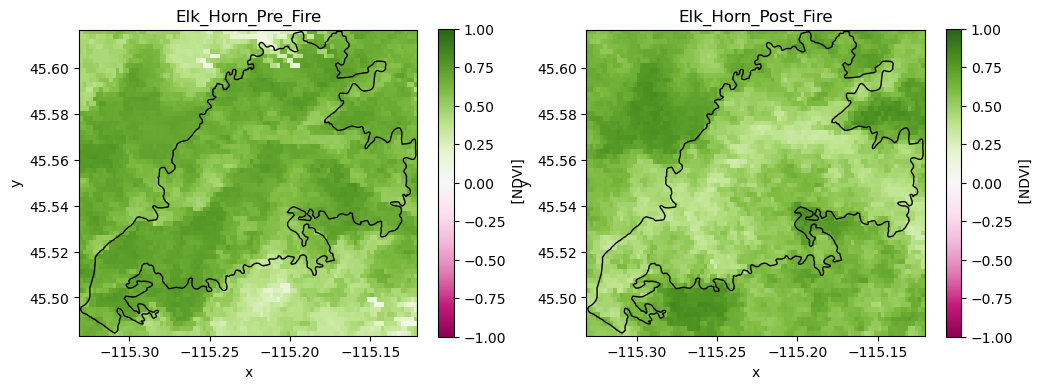

In [14]:
### plot first and last image side-my-side for comparison 
recent_ndvi= rxr.open_rasterio(ndvi_paths[-1], mask_and_scale=True).squeeze()
old_ndvi= rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze()

### creat sid by side-by-side subplots
fig, axes = plt.subplots(1 , 2, figsize=(12, 4))

### plot each in thier own axes
old_ndvi.plot(ax=axes[0], cmap=plt.cm.PiYG, vmin=-1, vmax=1)
elkhorn_id.plot(ax=axes[0], edgecolor='black', facecolor='none', linewidth=1)
axes[0].set_title("Elk_Horn_Pre_Fire")

recent_ndvi.plot(ax=axes[1], cmap=plt.cm.PiYG, vmin=-1, vmax=1)
elkhorn_id.plot(ax=axes[1], edgecolor='black', facecolor='none', linewidth=1)
axes[1].set_title("Elk_Horn_Post_Fire")

In [15]:
len(ndvi_da)

1

In [16]:
# Compute the difference in NDVI before and after of the water rights 2004
ndvi_diff = (ndvi_da
        .sel(date=slice('2023', '2025'))
        .mean('date')
        .NDVI 
     - ndvi_da
        .sel(date=slice('2020', '2023'))
        .mean('date')
        .NDVI
)
ndvi_diff

<xarray.DataArray 'NDVI' (y: 64, x: 101)> Size: 26kB
array([[ 0.04984045,  0.02853918,  0.02853918, ...,  0.00246781,
         0.00246781,  0.00462151],
       [ 0.06512976,  0.06512976,  0.02819765, ..., -0.00589293,
        -0.00213349, -0.00213349],
       [ 0.06440008,  0.0374881 ,  0.0374881 , ..., -0.00812972,
        -0.00812972,  0.00436914],
       ...,
       [-0.01119524,  0.0009833 ,  0.00015819, ...,  0.02811664,
         0.0411393 ,  0.0411393 ],
       [-0.00306559, -0.00538701, -0.00538701, ...,  0.03480223,
         0.03480223,  0.03394181],
       [-0.00438327,  0.00272375, -0.01017022, ...,  0.02523685,
         0.01496905,  0.03278452]], shape=(64, 101), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 808B -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 512B 45.62 45.61 45.61 45.61 ... 45.49 45.49 45.48
    spatial_ref  int64 8B 0

In [17]:
# plot the last tif image
rxr.open_rasterio(ndvi_diff, mask_and_scale=True).squeeze().plot()

TypeError: invalid path or file: <xarray.DataArray 'NDVI' (y: 64, x: 101)> Size: 26kB
array([[ 0.04984045,  0.02853918,  0.02853918, ...,  0.00246781,
         0.00246781,  0.00462151],
       [ 0.06512976,  0.06512976,  0.02819765, ..., -0.00589293,
        -0.00213349, -0.00213349],
       [ 0.06440008,  0.0374881 ,  0.0374881 , ..., -0.00812972,
        -0.00812972,  0.00436914],
       ...,
       [-0.01119524,  0.0009833 ,  0.00015819, ...,  0.02811664,
         0.0411393 ,  0.0411393 ],
       [-0.00306559, -0.00538701, -0.00538701, ...,  0.03480223,
         0.03480223,  0.03394181],
       [-0.00438327,  0.00272375, -0.01017022, ...,  0.02523685,
         0.01496905,  0.03278452]], shape=(64, 101), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 808B -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 512B 45.62 45.61 45.61 45.61 ... 45.49 45.49 45.48
    spatial_ref  int64 8B 0

In [18]:
# Plot the difference

(
    ndvi_diff.hvplot(x='x', y='y', cmap='PiYG', geo=True, 
                     title= 'Elkhorn Fire change from 2020 till 2025')
    *
    elkhorn_id.hvplot(geo=True, fill_color=None, line_color='black')
)

:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

In [19]:
# Plot the difference

elkhorn_ndvi=(
    ndvi_diff.hvplot(x='x', y='y', cmap='PiYG', geo=True, 
                     title= 'Elkhorn Fire change from 2020 till 2025')
    *
    elkhorn_id.hvplot(geo=True, fill_color=None, line_color='black')
)

In [21]:
# Save as html
hvplot.save(elkhorn_ndvi, 'elkhorn_ndvi.html')

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [69]:
%store elkhorn_id ndvi_da

Stored 'elkhorn_id' (GeoDataFrame)
Stored 'ndvi_da' (Dataset)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!